In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [5]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [49]:
df = pd.read_csv('./data/SR99_VDS1005210_2016_fill.csv', delimiter=';', parse_dates=True, index_col='datetime')

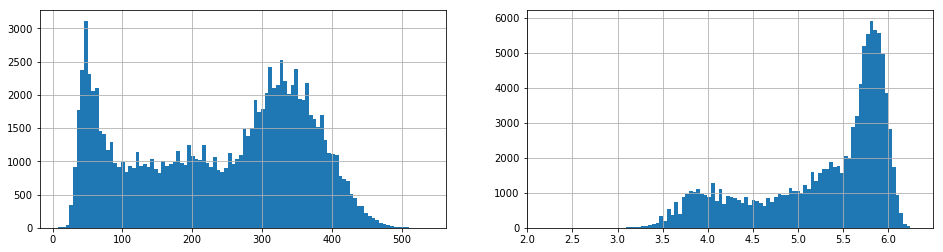

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
df['flow_5'].hist(bins=100, ax=axes[0])
df['flow_log'] = np.log1p(df['flow_5'])
df['flow_log'].hist(bins=100, ax=axes[1])
plt.show()

In [8]:
# 数据平滑

In [4]:
# 特征工程
# lagging=5
def creat_lagging(df, lagging):
    cols, names = list(), list()
    for i in range(lagging, -1, -1):
        cols.append(df.shift(i))
        names.append('lagging%d' % i)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

df_feture = creat_lagging(df, lagging=5)

# minute_of_hour
df_feture['minute'] = df.index.map(lambda date: date.minute)
# hour_of_day
df_feture['hour'] = df.index.map(lambda date: date.hour)
# day_of_week
df_feture['day_of_week'] = df.index.map(lambda date: date.weekday() + 1)
# day_of_month
# df_feture['day'] = df.index.map(lambda date: date.day)
# month_of_year
# df_feture['month'] = df.index.map(lambda date: date.month)
# vacation

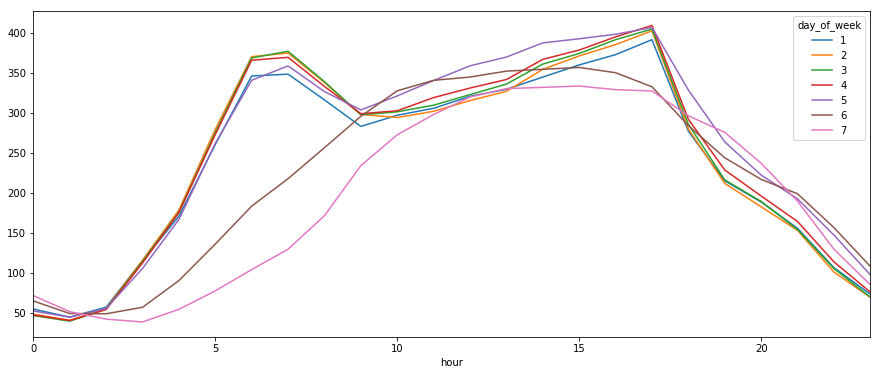

In [10]:
# 一天之内每小时平均流量的变化
df_feture.groupby(['hour', 'day_of_week'])['lagging0'].mean().unstack().plot()
plt.show()

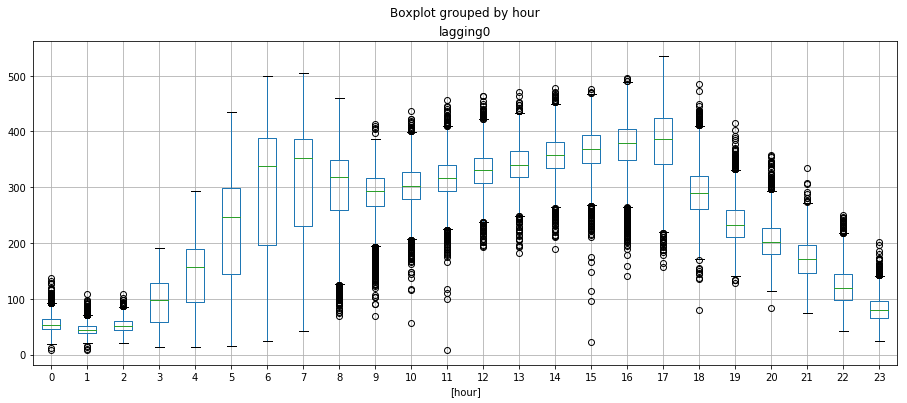

In [91]:
df_feture.boxplot(by=['hour'], column='lagging0')
plt.show()

In [5]:
df2 = pd.get_dummies(df_feture, columns=['day_of_week', 'hour', 'minute'])

In [51]:
df2.head(5)

,lagging5,lagging4,lagging3,lagging2,lagging1,lagging0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,minute_10,minute_15,minute_20,minute_25,minute_30,minute_35,minute_40,minute_45,minute_50,minute_55
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,28.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:05:00,NaN,NaN,NaN,NaN,28.0,31.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:10:00,NaN,NaN,NaN,28.0,31.0,34.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-01-01 00:15:00,NaN,NaN,28.0,31.0,34.0,57.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-01 00:20:00,NaN,28.0,31.0,34.0,57.0,76.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# 暂时先用这么多特征了
# 训练

In [40]:
df2 = df2.dropna()
train = df2[: '2016-09']  # 1-9训练
test = df2['2016-10' : '2016-11']  # 10、11测试
train_feature = train.drop('lagging0', axis=1).columns.values
X_train = train.drop('lagging0', axis=1).values
X_test = test.drop('lagging0', axis=1).values
y_train = train['lagging0'].values
y_test = test['lagging0'].values

In [7]:
regressor = xgb.XGBRegressor()

In [8]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
y_pre = regressor.predict(X_test)

In [10]:
y_pre

array([ 82.23782349,  79.08241272,  79.67047119, ...,  68.06623077,
        65.82431793,  62.99727631], dtype=float32)

In [11]:
def mape(y_true, y_predict):
    # Mean Absolute Percentage Error
    assert len(y_true) == len(y_predict)
    return np.mean(np.abs(y_true - y_predict)/np.abs(y_true)) * 100

In [12]:
mape(y_test, y_pre)

9.272357249774501

In [13]:
importances = regressor.feature_importances_

In [14]:
importances

array([ 0.04017217,  0.04878049,  0.07173601,  0.10186514,  0.21377331,
        0.        ,  0.        ,  0.        ,  0.        ,  0.01291248,
        0.0071736 ,  0.0143472 ,  0.00573888,  0.00430416,  0.00430416,
        0.02295552,  0.0143472 ,  0.03299857,  0.04591105,  0.00573888,
        0.01291248,  0.00143472,  0.        ,  0.        ,  0.00430416,
        0.00143472,  0.00860832,  0.00860832,  0.0143472 ,  0.03299857,
        0.03156384,  0.01147776,  0.0071736 ,  0.01291248,  0.01147776,
        0.00860832,  0.0215208 ,  0.00860832,  0.01865136,  0.02582496,
        0.02295552,  0.01147776,  0.        ,  0.00573888,  0.00286944,
        0.01721664,  0.02008608,  0.03012913], dtype=float32)

In [42]:
indices = np.argsort(-importances)

In [41]:
train_feature

array(['lagging5', 'lagging4', 'lagging3', 'lagging2', 'lagging1',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'minute_0',
       'minute_5', 'minute_10', 'minute_15', 'minute_20', 'minute_25',
       'minute_30', 'minute_35', 'minute_40', 'minute_45', 'minute_50',
       'minute_55'], dtype=object)

In [43]:
selected_features = [train_feature[e] for e in indices]

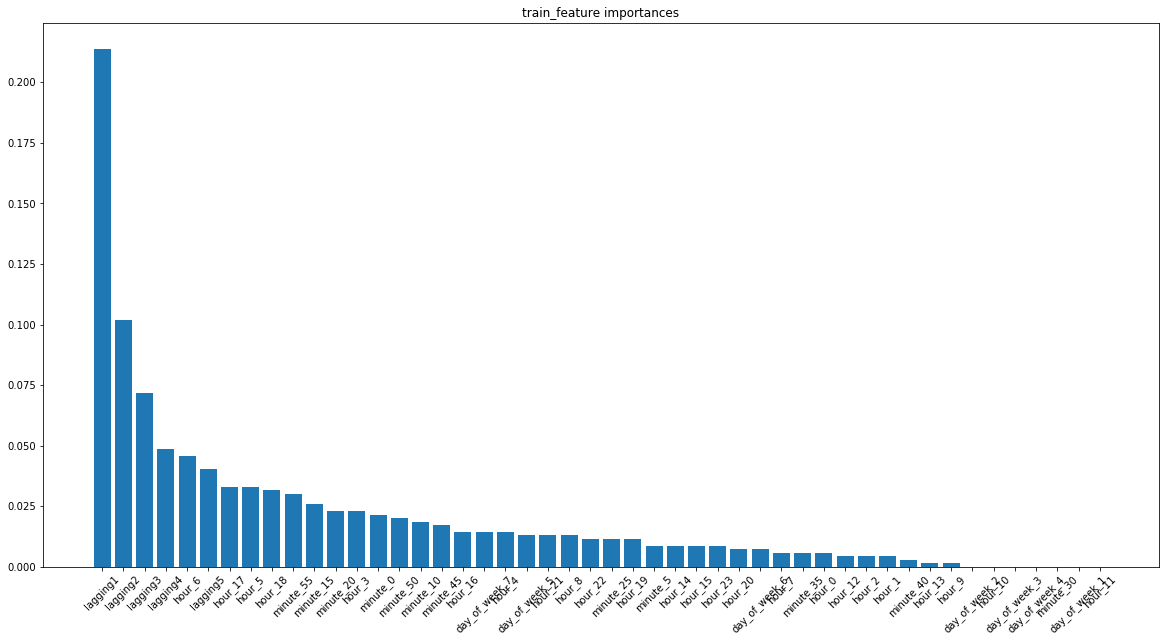

In [48]:
plt.figure(figsize=(20, 10))
plt.title("train_feature importances")
plt.bar(range(len(train_feature)), importances[indices])
plt.xticks(range(len(selected_features)), selected_features, rotation=45)
plt.show()

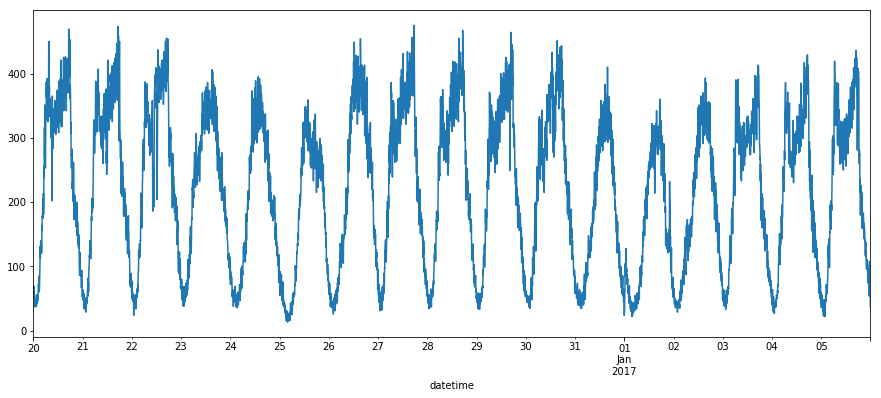

In [23]:
df['2016-12-20':'2017-01-05']['flow_5'].plot()
plt.show()

In [3]:
np.sign([1,-2,3, 4])

array([ 1, -1,  1,  1])